In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

import seaborn as sns
import matplotlib.pyplot as plt

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)
    
path_to_hnets = './Models/Models_HNET_Block3'

In [3]:
experiment0_hnet_v0 = 'Experiment13_Task3_emb12_batch50_30epochs'
models_exp0_hnet_v0 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v0)))


path_results_exp0_v0 = './Results/' + experiment0_hnet_v0
with open(os.path.join(path_results_exp0_v0 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v0 = pickle.load(fp)

data_path_exp0_v0 = './Data/Sim_Data_Experiment60_sorted'+'.pkl'
with open(os.path.join(data_path_exp0_v0), 'rb') as fp:
    data_exp0_v0 = pickle.load(fp)

In [4]:
results_hnet_exp0_v0['Data_0_1'].keys()

dict_keys(['y_true_hnet', 'y_pred_hnet', 'r2_test_hnet', 'hnet_train_losses', 'hnet_val_losses', 'training_time', 'change_detect_epoch', 'prev_active_context', 'prev_min_loss', 'prev_mean_loss', 'new_tested_context', 'new_loss', 'new_mean_loss', 'similarity_score', 'active_context'])

In [5]:
model1 = torch.load(os.path.join(path_to_hnets,experiment0_hnet_v0, models_exp0_hnet_v0[1] ))
model2 = torch.load(os.path.join(path_to_hnets,experiment0_hnet_v0, models_exp0_hnet_v0[3] ))


In [6]:
first_task = list(data_exp0_v0.keys())[1]

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = data_exp0_v0[first_task]
W_1 = model1(cond_id = 1)
W_2 = model2(cond_id = 1)


In [8]:
main_net = RNN_Main_Model(num_features= 130, hnet_output = W_1,  hidden_size = 300,
                                        num_layers= 1,out_dims=2,  
                                        dropout= 0.2,  LSTM_ = True)

In [9]:
r2_1, _ = calc_explained_variance_mnet(x_test, y_test, W_1, main_net)
r2_1

0.8941683769226074

In [10]:
r2_2, _ = calc_explained_variance_mnet(x_test, y_test, W_2, main_net)
r2_2


0.8678718507289886

In [11]:
task_performances = {}
best_perf = {}
for d in data_exp0_v0.keys():
    x_train, y_train, x_val, y_val, x_test, y_test = data_exp0_v0[d]
    data_perf = []
    model = torch.load(os.path.join(path_to_hnets,experiment0_hnet_v0, models_exp0_hnet_v0[-1] ))
    for cond in range(len(models_exp0_hnet_v0)):
        W = model(cond_id = cond)
        r2_, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
        data_perf.append(r2_)
    task_performances[d] = data_perf
    best_perf[d] = max(data_perf)


In [12]:
best_perf

{'Data_0_1': 0.8594086170196533,
 'Data_2_2': 0.8679263591766357,
 'Data_4_1': 0.6744422912597656,
 'Data_3_1': 0.8217892050743103,
 'Data_1_2': 0.8700138926506042,
 'Data_3_2': 0.8214361071586609,
 'Data_4_2': 0.6599255502223969,
 'Data_0_2': 0.8857744336128235,
 'Data_1_1': 0.8238453269004822,
 'Data_2_1': 0.8394283056259155}

In [13]:
results_hnet_exp0_v0['Data_0_1'].keys()

dict_keys(['y_true_hnet', 'y_pred_hnet', 'r2_test_hnet', 'hnet_train_losses', 'hnet_val_losses', 'training_time', 'change_detect_epoch', 'prev_active_context', 'prev_min_loss', 'prev_mean_loss', 'new_tested_context', 'new_loss', 'new_mean_loss', 'similarity_score', 'active_context'])

In [14]:
keys_to_extract = ['change_detect_epoch', 'prev_active_context', 'prev_min_loss', 'prev_mean_loss', 'new_tested_context', 'new_loss', 'new_mean_loss', 'active_task']

In [15]:
# Move tensors to CPU and convert to lists, handle non-tensor values appropriately
def generate_dict_changes(dataset, keys_to_extract):
    filtered_data = {}
    results = results_hnet_exp0_v0[dataset]
    for key in keys_to_extract:
        if key in results:
            value = results[key]
            if len(value)>0:
                if isinstance(value[0], torch.Tensor):
                    filtered_data[key] = [tensor.cpu().item() for tensor in value]
                else:
                    filtered_data[key] = value
                    
    return pd.DataFrame(filtered_data)

In [16]:
results_hnet_exp0_v0.keys()

dict_keys(['Data_0_1', 'Data_2_2', 'Data_4_1', 'Data_3_1', 'Data_1_2', 'Data_3_2', 'Data_4_2', 'Data_0_2', 'Data_1_1', 'Data_2_1'])

In [17]:
keys = list(results_hnet_exp0_v0.keys())
data_dict1 = generate_dict_changes(keys[1], keys_to_extract)
data_dict1['Dataset'] = keys[1]
data_dict1['Active Context'] = 1
data_dict2 = generate_dict_changes(keys[2], keys_to_extract)
data_dict2['Dataset'] = keys[2]
data_dict2['Active Context'] = 2
data_dict3 = generate_dict_changes(keys[3], keys_to_extract)
data_dict3['Dataset'] = keys[3]
data_dict3['Active Context'] = 3 
data_dict4 = generate_dict_changes(keys[4], keys_to_extract)
data_dict4['Dataset'] = keys[4]
data_dict4['Active Context'] = 4 
data_dict5 = generate_dict_changes(keys[5], keys_to_extract)
data_dict5['Dataset'] = keys[5]
data_dict5['Active Context'] = 5
data_dict6 = generate_dict_changes(keys[6], keys_to_extract)
data_dict6['Dataset'] = keys[6]
data_dict6['Active Context'] = 5 
data_dict7 = generate_dict_changes(keys[7], keys_to_extract)
data_dict7['Dataset'] = keys[7]
data_dict7['Active Context'] = 6 
data_dict8 = generate_dict_changes(keys[8], keys_to_extract)
data_dict8['Dataset'] = keys[8]
data_dict8['Active Context'] = 4
data_dict9 = generate_dict_changes(keys[9], keys_to_extract)
data_dict9['Dataset'] = keys[9]
data_dict9['Active Context'] = 7
dataframes = [data_dict1, data_dict2, data_dict3, data_dict4, data_dict5, data_dict6, data_dict7, data_dict8, data_dict9]
df_changes = pd.concat(dataframes, ignore_index=True)

In [18]:
def true_task_dict(data):
    max_id = 0
    found_ids = []
    true_task_map = {}
    for d in data.keys():
        new_id = d.split('_')[1]
        if new_id not in found_ids:
            found_ids.append(new_id)
            true_task_map[d] = max_id
            max_id += 1
        else:
            idx_id = found_ids.index(new_id)
            true_task_map[d] = idx_id

    return true_task_map

In [19]:
task_dict = true_task_dict(data_exp0_v0)

In [20]:
task_dict

{'Data_0_1': 0,
 'Data_2_2': 1,
 'Data_4_1': 2,
 'Data_3_1': 3,
 'Data_1_2': 4,
 'Data_3_2': 3,
 'Data_4_2': 2,
 'Data_0_2': 0,
 'Data_1_1': 4,
 'Data_2_1': 1}

In [21]:
df_changes['Task'] = df_changes['Dataset'].apply(lambda x: task_dict[x])
df_changes = df_changes.loc[df_changes.change_detect_epoch == 0]
df_changes

,change_detect_epoch,prev_active_context,prev_min_loss,prev_mean_loss,new_tested_context,new_loss,new_mean_loss,Dataset,Active Context,Task
0,0,0,4.0735097,0.5941658,0,3.7271802,1.425998,Data_2_2,1,1
1,0,1,4.380494,0.58576435,0,9.083677,1.544831,Data_4_1,2,2
2,0,1,4.380494,0.58576435,1,5.7706175,1.405834,Data_4_1,2,2
3,0,2,10.432378,2.9606466,0,9.755122,1.663664,Data_3_1,3,3
4,0,2,10.432378,2.9606466,1,14.789295,1.522987,Data_3_1,3,3
5,0,2,10.432378,2.9606466,2,14.477949,7.105552,Data_3_1,3,3
6,0,3,8.183767,0.95229673,0,12.91496,1.782498,Data_1_2,4,4
7,0,3,8.183767,0.95229673,1,12.819353,1.640140,Data_1_2,4,4
8,0,3,8.183767,0.95229673,2,16.040037,7.697681,Data_1_2,4,4
9,0,3,8.183767,0.95229673,3,9.976018,2.285512,Data_1_2,4,4


In [22]:
def set_plot_style():
    # Define the custom color palette
    custom_palette = [
        '#5F9EA0', # cadet blue
        '#FFD700', # gold
        '#FFA07A', # light salmon
        '#87CEEB', # light blue
        '#9370DB', # medium purple
        '#98FB98'  # pale green
    ]
    
    # Set the Seaborn palette
    sns.set_palette(custom_palette)
    
    # Set general plot aesthetics
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    # Update Matplotlib rcParams for consistent styling
    plt.rcParams.update({
        'figure.figsize': (12, 7),
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.title_fontsize': 13,
        'legend.fontsize': 11,
        'axes.titlepad': 20,
        'axes.labelpad': 10,
        'xtick.major.pad': 5,
        'ytick.major.pad': 5
    })

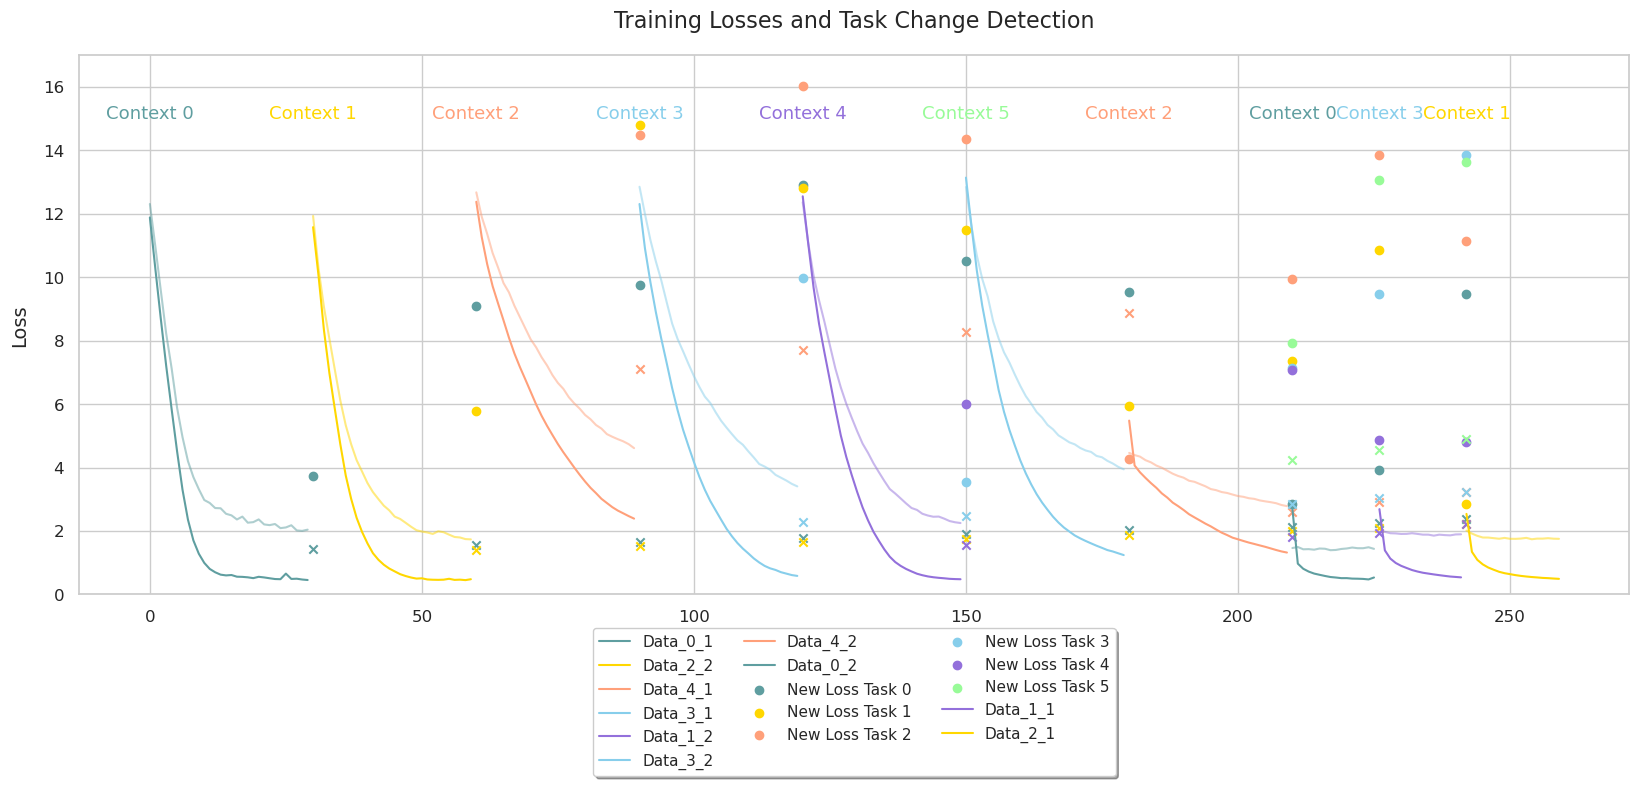

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sample DataFrame creation for demonstration (you can skip this if you already have df_changes)
# df_changes = pd.read_csv('path_to_your_dataframe.csv')  # Use this line to load your DataFrame

# Assuming df_changes and results_hnet_exp0_v0 are already defined

# Plot settings
plt.figure(figsize=[20, 7])

set_plot_style()

custom_palette = [
    '#5F9EA0',  # cadet blue
    '#FFD700',  # gold
    '#FFA07A',  # light salmon
    '#87CEEB',  # light blue
    '#9370DB',  # medium purple
    '#98FB98',  # pale green
    '#FF7F50',  # coral
    '#FF69B4',  # hot pink
    '#20B2AA',  # light sea green
    '#FF6347',  # tomato
    '#4682B4',  # steel blue
    '#DA70D6',  # orchid
    '#32CD32'   # lime green
]

# Plot the training losses for each task
task_data_keys = list(results_hnet_exp0_v0.keys())
unique_tasks = range(len(task_data_keys))
#colors = sns.color_palette("hsv", len(unique_tasks))
color_map = {task: custom_palette[i] for i, task in enumerate(unique_tasks)}

highest_tested_task = np.max(df_changes.new_tested_context.unique())
dataset_legend = df_changes.loc[df_changes.new_tested_context == highest_tested_task]['Dataset'].values
if len(dataset_legend) > 1:
    dataset_legend = dataset_legend[0]

contexts_found_Experiment9_61 = ['Context 0', 'Context 0', 'Context 1', 'Context 0', 
                  'Context 0', 'Context 2', 'Context 3', 'Context 4',
                  'Context 2', 'Context 4']

contexts_found_Experiment9_Test = ['Context 0', 'Context 1', 'Context 2', 'Context 3', 
                  'Context 4', 'Context 5', 'Context 2', 'Context 0',
                  'Context 4', 'Context 1']

contexts_found_Experiment9_61_sorted = ['Context 0', 'Context 1', 'Context 2', 'Context 3', 
                  'Context 0', 'Context 4', 'Context 0', 'Context 0',
                  'Context 1', 'Context 2']

contexts_found_Experiment9_61_sorted = ['Context 0', 'Context 0', 'Context 1', 'Context 2', 
                  'Context 3', 'Context 4', 'Context 5', 'Context 6',
                  'Context 7', 'Context 8']

contexts_found_Experiment13_sorted = ['Context 0', 'Context 1', 'Context 2', 'Context 3', 
                  'Context 4', 'Context 3', 'Context 2', 'Context 0',
                  'Context 4', 'Context 1']

contexts_found_Experiment13_sorted_alltrials = ['Context 0', 'Context 1', 'Context 2', 'Context 3', 
                  'Context 4', 'Context 5', 'Context 6', 'Context 0',
                  'Context 4', 'Context 1']

contexts_found_Experiment13_sorted_emb12 = ['Context 0', 'Context 1', 'Context 2', 'Context 3', 
                  'Context 4', 'Context 5', 'Context 6', 'Context 0',
                  'Context 4', 'Context 1']

contexts_found_Experiment13_sorted_emb12_batch50 = ['Context 0', 'Context 1', 'Context 2', 'Context 3', 
                  'Context 4', 'Context 3', 'Context 5', 'Context 0',
                  'Context 4', 'Context 1']

contexts_found_Experiment13_sorted_emb12_batch50_25epochs = ['Context 0', 'Context 1', 'Context 2', 'Context 2', 
                  'Context 3', 'Context 2', 'Context 3', 'Context 0',
                  'Context 3', 'Context 1']

contexts_found_Experiment13_sorted_emb12_batch50_30epochs = ['Context 0', 'Context 1', 'Context 2', 'Context 3', 
                  'Context 4', 'Context 5', 'Context 2', 'Context 0',
                  'Context 3', 'Context 1']




start_epoch = 0
for i, key in enumerate(task_data_keys):
    task = task_dict[key]
    if i < len(task_data_keys):
        start_epoch = start_epoch
        end_epoch = start_epoch + len(results_hnet_exp0_v0[key]['hnet_train_losses'])
        plt.plot(
            np.arange(start_epoch, end_epoch), 
            results_hnet_exp0_v0[key]['hnet_train_losses'], 
            label=key,
            color= color_map[task] , #color_map[task]
        )

        plt.plot(
            np.arange(start_epoch, end_epoch), 
            results_hnet_exp0_v0[key]['hnet_val_losses'], 
            color=color_map[task],
            alpha = 0.5
        )
        plt.text(
            start_epoch, 
            15,
            #f"Context: {data_new_task['Active Context'].values[0]}",
            contexts_found_Experiment13_sorted_emb12_batch50_30epochs[i],
            fontsize=13,
            color=color_map[int(contexts_found_Experiment13_sorted_emb12_batch50_30epochs[i][-1])],
            ha='center'
            )
    
    # Scatter plot for change detection and losses
    if key in df_changes.Dataset.unique():
        changes_dataset = df_changes[df_changes.Dataset == key]   

    
        if len(changes_dataset.Task.unique()) > 0:
            task = int(changes_dataset.Task.unique())
            for new_task in changes_dataset.new_tested_context.unique():
                data_new_task = changes_dataset[changes_dataset.new_tested_context == new_task]
                if key == dataset_legend:
                    plt.scatter(
                        #(data_new_task.prev_active_context + 1) * 15, 
                        start_epoch,
                        data_new_task['new_loss'], 
                        color=color_map[new_task], 
                        label=f'New Loss Task {new_task}', 
                        marker='o'
                    )
                else:
                    plt.scatter(
                        #(data_new_task.prev_active_context + 1) * 15, 
                        start_epoch,
                        data_new_task['new_loss'], 
                        
                        color=color_map[new_task], 
                        #label=f'New Loss Task {new_task}', 
                        marker='o'
                    )

                plt.scatter(
                    start_epoch,
                    #(data_new_task.prev_active_context + 1) * 15, 
                    data_new_task['new_mean_loss'], 
                    color=color_map[new_task], 
                    
                    #label=f'Mean Loss Task {new_task}', 
                    marker='x'
                )
                
    start_epoch = end_epoch

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses and Task Change Detection')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=3, fancybox=True, shadow=True)
plt.ylim([0, 17])
plt.show()

In [24]:
kwargs = {"a":0, "b":0, "c":0}

def g(c): 
    return c

def f(a,b, **kwargs):
    return a*b + g(**kwargs)